# Before you attempt to run this notebook, read this

Thanks for downloading this notebook! The code here will "just work" if you do three things:

1. Point this notebook at your S3 bucket in the cell of this notebook.
2. Run this notebook with an IAM Role that has `AmazonSageMakerFullAccess`, `AWSDataExchangeSubscriberFullAccess`, and `[ "s3:GetObject", "s3:PutObject", "s3:DeleteObject", "s3:ListBucket" ]` on whichever S3 bucket you're going to use.
3. An existing subscription to [Stats Perform Fantasy Player Data](https://console.aws.amazon.com/dataexchange/home?region=us-east-1#/products/prodview-tte3yvctdjs7a).

In [1]:
# Replace this bucket with your own S3 bucket
bucket = 'lineup-optimizer-demo-226bbd09-5c06-42d7-acc4-ce34b3c0c3e6'

Install boto3 1.10 which has support for `dataexchange`.

In [2]:
import sys
!{sys.executable} -m pip install --force --no-deps boto3==1.10

  Using cached boto3-1.10.0-py2.py3-none-any.whl (128 kB)
  Attempting uninstall: boto3
    Found existing installation: boto3 1.10.0
    Uninstalling boto3-1.10.0:
      Successfully uninstalled boto3-1.10.0


<hr style="border:2px solid gray"> </hr>

# Step 1: Export Stats Perform data from AWS Data Exchange to your S3 Bucket

Set the bucket we'll use to export data. You'll want to replace this with your bucket.

Set the resource IDs that refer to the Stats Perform data we need. If you have a subscription to the [Stats Perform product](https://console.aws.amazon.com/dataexchange/home?region=us-east-1#/products/prodview-tte3yvctdjs7a), you'll be able to export these data sets.

In [3]:
stats_perform_predictions_data_set_id = 'bbbaa790d1fb4eb1e90ccc5d4e74f774'
stats_perform_salary_data_set_id = '3a0049b13e2018d20898334c7bb0c636'
stats_perform_odds_data_set_id = '3b4fcf7d131ebef8584a8b8088417424'
stats_perform_box_score_data_set_id = '20557179573f3af759e70358077edcb7'
stats_perform_player_reference_data_set_id = '4ebbb5702ae5cd66eebbd58f72210ccf'

In [4]:
import boto3

dx = boto3.client('dataexchange', region_name = 'us-east-1')

In [5]:
# We assume usage of the first Revision of the Data Sets published by Stats Perform.
# If Stats Perform publishes updated data that you want to use, point at the approrpriate (or latest) Revision.

predictions_revision_id = dx.list_data_set_revisions(DataSetId = stats_perform_predictions_data_set_id)['Revisions'][0].get('Id')
predictions_assets = dx.list_revision_assets(DataSetId = stats_perform_predictions_data_set_id, RevisionId = predictions_revision_id)['Assets']

salary_revision_id = dx.list_data_set_revisions(DataSetId = stats_perform_salary_data_set_id)['Revisions'][0].get('Id')
salary_assets = dx.list_revision_assets(DataSetId = stats_perform_salary_data_set_id, RevisionId = salary_revision_id)['Assets']

odds_revision_id = dx.list_data_set_revisions(DataSetId = stats_perform_odds_data_set_id)['Revisions'][0].get('Id')
odds_assets = dx.list_revision_assets(DataSetId = stats_perform_odds_data_set_id, RevisionId = odds_revision_id)['Assets']

box_score_revision_id = dx.list_data_set_revisions(DataSetId = stats_perform_box_score_data_set_id)['Revisions'][0].get('Id')
box_score_assets = dx.list_revision_assets(DataSetId = stats_perform_box_score_data_set_id, RevisionId = box_score_revision_id)['Assets']

player_reference_revision_id = dx.list_data_set_revisions(DataSetId = stats_perform_player_reference_data_set_id)['Revisions'][0].get('Id')
player_reference_assets = dx.list_revision_assets(DataSetId = stats_perform_player_reference_data_set_id, RevisionId = player_reference_revision_id)['Assets']

In [6]:
import time

def export_assets(assets):
    asset_destinations = []

    for asset in assets:
        asset_name_with_out_path = asset.get('Name').split('/')[-1]
        
        asset_destinations.append({
            "AssetId": asset.get('Id'),
            "Bucket": bucket,
            "Key": 'statsperform/{}'.format(asset_name_with_out_path)
        })
    
    job = dx.create_job(Type = 'EXPORT_ASSETS_TO_S3', Details = {
        "ExportAssetsToS3": {
            "RevisionId": assets[0].get("RevisionId"), "DataSetId": assets[0].get("DataSetId"),
            "AssetDestinations": asset_destinations
        }
    })
        
    job_id = job.get('Id')
    
    dx.start_job(JobId = job_id)

    while True:
        job = dx.get_job(JobId = job_id)

        if job.get('State') == 'COMPLETED':
            break
        elif job.get('State') == 'ERROR':
            raise Exception("Job {} failed to complete - {}".format(
                job_id, job.get('Errors')[0].get('Message'))
            )

        time.sleep(1)

In [7]:
export_assets(predictions_assets)
export_assets(salary_assets)
export_assets(odds_assets)
export_assets(box_score_assets)
export_assets(player_reference_assets)

# Step 1 Complete: Stats Perform data has been exported to your S3 Bucket

In [8]:
import boto3
for file in boto3.resource('s3').Bucket(bucket).objects.all():
    print(file.key)

statsperform/boxScoreByPlayer.csv
statsperform/boxScoreByPlayer.json
statsperform/fantasyPredictions.csv
statsperform/fantasyPredictions.json
statsperform/fantasySalaries.csv
statsperform/fantasySalaries.json
statsperform/odds.csv
statsperform/odds.json
statsperform/players.csv
statsperform/players.json


<hr style="border:2px solid gray"> </hr>

# Step 2: Join Stats Perform data (odds, historical performance, and player reference data) to train the ML model

In [9]:
odds_location = 's3://{}/statsperform/odds.json'.format(bucket)
history_location = 's3://{}/statsperform/boxScoreByPlayer.json'.format(bucket)
player_reference_location = 's3://{}/statsperform/players.json'.format(bucket)
salary_location = 's3://{}/statsperform/fantasySalaries.json'.format(bucket)
fantasy_predictions_location = 's3://{}/statsperform/fantasyPredictions.json'.format(bucket)

## Create dataframe for training

Now that we have the Stats Perform data from AWS Data Exchange, we merge the historical data, odds data, and player reference data so that we know how each player did in their games by season and week, including the position they played, and the odds for that game.


In [10]:
import pandas as pd

In [11]:
historical_df = pd.read_json(history_location)

In [12]:
odds_df = pd.read_json(odds_location)

In [13]:
players_df = pd.read_json(player_reference_location).rename(columns = { 'playerid': 'player_id' })

In [14]:
joined_df = pd.merge(historical_df, odds_df, how = 'left', left_on = [ 'week', 'fixture_id' ], right_on = [ 'week', 'fixture_id' ])

In [15]:
joined_df = joined_df.set_index([ 'player_id', 'season' ]).join(players_df.set_index([ 'player_id', 'season' ])).reset_index()

Drop rows that are missing data.

In [16]:
joined_df = joined_df.dropna(subset = [ 
    'player_id', 
    'team_id', 
    'positionname', 
    'season', 
    'week', 
    'line', 
    'favorite_points',
    'favorite_team_id'
]).fillna(0)

Map long position names to short position abbreviations and rename the column. For example, Tight End to TE. This makes it easier to join with predictions and salary data from Stats Perform later on in the notebook.

In [17]:
joined_df['positionname'] = joined_df['positionname'].replace([ 'Tight End', 'Running Back', 'Wide Receiver', 'Quarterback' ], [ 'TE', 'RB', 'WR', 'QB' ])

In [18]:
joined_df = joined_df.rename(columns = { 'positionname': 'position' })

Filter down to offensive players. Note this model doesn't optimize lineups including DSTs but, the Stats Perform data contains individual defensive player and this can be calculated by aggregating that data.

In [19]:
joined_df = joined_df[joined_df['position'].isin([ 'TE', 'RB', 'WR', 'QB' ])]

Rename the odds columns to match the terms we used in our slides.

In [20]:
joined_df = joined_df.rename(columns = { 'line': 'ou', 'favorite_points': 'spread' })

Turn the O/U and Spread into an implied score for the player's team and an implied score for the opponent's team as this is an easy way to represent the data to our ML model.

In [21]:
def implied_game_score(x):
    ou = x['ou']
    abs_spread = abs(x['spread'])
    
    favored_score = ((ou - abs_spread) / 2) + abs_spread
    underdog_score = ((ou - abs_spread) / 2)
    
    return favored_score if x['team_id'] == x['favorite_team_id'] else underdog_score

In [22]:
def opponent_implied_game_score(x):
    ou = x['ou']
    abs_spread = abs(x['spread'])
    
    favored_score = ((ou - abs_spread) / 2) + abs_spread
    underdog_score = ((ou - abs_spread) / 2)
    
    return underdog_score if x['team_id'] == x['favorite_team_id'] else favored_score

In [23]:
joined_df['implied_game_score'] = joined_df.apply(implied_game_score, axis = 1)

In [24]:
joined_df['opponent_implied_game_score'] = joined_df.apply(opponent_implied_game_score, axis = 1)

With all of the data joined in a single dataframe, filter down to the columns we need:
* `player_id`: So we can uniquely identify each player.
* `season`: This splits the data up by year. This way we can run our trained model against one of the years in this dataframe so we can see how the model performed.
* `week`: Tells which week the game was played.
* `fixture_id`: Uniquely IDs each game which is useful later on when we join against Predictions data from Stats Perform.
* `position`: The position played.
* `rush_yds`: The yards rushed by the played. Used for scoring.
* `rush_tds`: The number of rushing touchdowns. Used for scoring.
* `pass_yds`: The yards thrown by the QB. Used for scoring.
* `pass_tds`: The touchdowns thrown by the QB. Used for scoring.
* `recs`: The number of catches made by the player. Used for scoring.
* `rec_yds`: The number of receiving yards. Used for scoring.
* `rec_tds`: The numer of receiving touchdowns. Used for scoring.
* `pass_atts`: The number of times the QB passed the ball. We use this field when training our model to filter out QBs that aren't starters and as a feature when predicting upside from odds.
* `rush_atts`: The number of times the RB had a chance to rush with the football. We use this field when training our model to filter out RBs that don't get a lot touches as a feature when predicting upside from odds.
* `rec_targets`: The number of times the player was targeted for a catch. We use this field when training our model to filter out WRs and TEs that don't get a lot of targets as a feature when predicting upside from odds.
* `implied_game_score`:  Total points the odds predict the player's team will score. Used as a feature for our ML model.
* `opponent_implied_game_score`: Total points the odds predict the player's opponent will score. Used as a feature for our ML model.

In [25]:
scoring_df = joined_df.reset_index()[[
    'player_id',
    'team_id', 
    'season', 
    'week',
    'fixture_id',
    'position',
    'rush_yds', 
    'rush_tds',
    'pass_yds', 
    'pass_tds',
    'recs', 
    'rec_yds', 
    'rec_tds',
    'pass_atts',
    'rush_atts',
    'rec_targets',
    'implied_game_score',
    'opponent_implied_game_score'
]]

## Score player points

We use a standard PPR (point per reception) scoring function.
* Each passing yard gives the player 0.04 points (`pass_yds`).
* Each passing touchdown gives the player 4 points (`pass_tds`).
* Each rushing yard gives the player 0.1 points (`rush_yds`).
* Each rushing touchdown gives the player 6 popints (`rush_tds`).
* Each receiving yard gives the player 0.1 points (`rec_yds`).
* Each reception gives the player a point (`recs`).
* Each receiving touchdown gives the player 6 points (`rec_tds`).

In [26]:
def points_scored(player):
    total = 0.0
    
    total += player['pass_yds'] * 0.04
    total += player['pass_tds'] * 4
    total += player['rush_yds'] * 0.1
    total += player['rush_tds'] * 6
    total += player['recs']
    total += player['rec_yds'] * 0.1
    total += player['rec_tds'] * 6
    
    return total

In [27]:
scoring_df['actual_points'] = scoring_df.apply(points_scored, axis = 1)

# Step 2 Complete: Your data is ready to train the ML model

In [28]:
scoring_df.sample(n = 10)

,player_id,team_id,season,week,fixture_id,position,rush_yds,rush_tds,pass_yds,pass_tds,recs,rec_yds,rec_tds,pass_atts,rush_atts,rec_targets,implied_game_score,opponent_implied_game_score,actual_points
33642,877745,366,2019,9,2142152,QB,61.0,2.0,163.0,1.0,0.0,0.0,0.0,23.0,16.0,0.0,20.75,23.75,28.62
3143,285900,350,2017,1,1744861,RB,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,22.25,25.25,0.20
22124,609050,332,2016,12,1635776,WR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,21.75,18.25,0.00
6955,399939,363,2015,17,1540399,WR,0.0,0.0,0.0,0.0,3.0,49.0,1.0,0.0,0.0,4.0,19.00,22.00,13.90
31132,822756,351,2016,18,1635922,WR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.25,25.75,0.00
18584,593518,325,2017,3,1744803,WR,0.0,0.0,0.0,0.0,1.0,15.0,0.0,0.0,0.0,4.0,15.50,29.00,2.50
3044,273753,329,2016,16,1635740,TE,0.0,0.0,0.0,0.0,5.0,42.0,0.0,0.0,0.0,6.0,20.50,25.00,9.20
15112,553688,331,2017,4,1744878,RB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,27.75,22.75,0.00
9224,461274,364,2016,2,1635751,WR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.00,16.00,0.00
21373,607435,334,2019,10,2142052,WR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15.75,22.25,0.00


<hr style="border:2px solid gray"> </hr>

# Step 3: Setup to train your models

## Describe the models

Here we create a hash that we reuse throughout the remainder of this notebook to tell us the features used as inputs for each player by position, along with qualifiers for inclusion in the model and inference later on when optimizing lineups.

For all positions, we use `implied_game_score` and `opponent_implied_game_score` as features to the ML model. As discussed during the presentation, we're using these features to predict if a player is likely to score points.

We filter out QBs that have fewer than 10 `pass_atts`. We also use `pass_atts` and `rush_atts` as features.

We filter our WRs that have fewer than 5 `rec_targets`. We also use `rec_targets` as a feature.

We filter out RBs that have fewer than 5 `rush_atts`. We also use `rec_targets` and `rush_atts` as features.

We filter out TEs that have fewer than 3 `rec_targets`. We also use `rec_targets` as a feature.

For all positions, we label the player for consideration in our lineups if they're in the upper quantile (per position) of scoring for all of the data points we have.

In [29]:
predictions = {
    'QB': { 
        'features': [
            'implied_game_score', 
            'opponent_implied_game_score',
            'rush_atts',
            'pass_atts'
        ], 
        'start_quantile': .5, 
        'qualifier_field': 'pass_atts', 
        'qualifier_value': 10 
    },
    'WR': { 
        'features': [
            'implied_game_score', 
            'opponent_implied_game_score',
            'rec_targets'
        ], 
        'start_quantile': .3, 
        'qualifier_field': 'rec_targets', 
        'qualifier_value': 5 
    },
    'RB': { 
        'features': [
            'implied_game_score', 
            'opponent_implied_game_score',
            'rush_atts',
            'rec_targets'
        ], 
        'start_quantile': .4, 
        'qualifier_field': 'rush_atts', 
        'qualifier_value': 8 
    },
    'TE': { 
        'features': [
            'implied_game_score', 
            'opponent_implied_game_score',
            'rec_targets'
        ], 
        'start_quantile': .5, 
        'qualifier_field': 'rec_targets', 
        'qualifier_value': 3 
    }
}

We continue to fill out the hash created in the previous step.

1. We remove players that don't qualify based on the qualifiers above.
2. We get the points scored for the quantile specified above.
3. We label the player as someone that we should start in our lineup if they're above our quantile cutoff.
4. We convert all fields to float32 as required by SageMaker.
5. Finally, we take 80% of the data we have to train the model and leave 20% for verification later on to calculate Recall, Precision, and the F1 Score.

Note, we use 40% and above for RBs and 30% and above for WRs otherwise the model aggressively labels players as not having upside from the odds, leaving us with too few players later on to fill a lineup.

In [30]:
for position in predictions:
    features = predictions[position]['features']

    fields = features[:]
    fields.append('actual_points')

    qualifier_field = predictions[position]['qualifier_field']
    qualifier_value = predictions[position]['qualifier_value']

    predictions[position]['predictions_df'] = scoring_df[
        (scoring_df['position'] == position) &
        (scoring_df[qualifier_field] > qualifier_value)
    ][fields]

    start_quantile = predictions[position]['start_quantile']
    predictions[position]['minimum_points_wanted'] = predictions[position]['predictions_df'][['actual_points']].quantile([start_quantile]).values[0][0]

    predictions[position]['predictions_df']['has_upside'] = predictions[position]['predictions_df'].apply(
        lambda x: 1 if x['actual_points'] >= predictions[position]['minimum_points_wanted'] else 0, axis=1
    )

    predictions[position]['predictions_df'] = predictions[position]['predictions_df'].astype('float32')

    vectors = predictions[position]['predictions_df'][features].values
    labels = predictions[position]['predictions_df']['has_upside'].values

    index = int(round(.8 * len(vectors)))

    predictions[position]['training_vectors'] = vectors[index:]
    predictions[position]['training_labels'] = labels[index:]

    predictions[position]['verification_vectors'] = vectors[:index]
    predictions[position]['verification_labels'] = labels[:index]

# Step 3 Complete: You're ready to train the models

In [31]:
for position in predictions:
    print('Position: {}, start if above: {}'.format(position, round(predictions[position]['minimum_points_wanted'], 2)))

Position: QB, start if above: 17.32
Position: WR, start if above: 9.8
Position: RB, start if above: 10.84
Position: TE, start if above: 9.6


<hr style="border:2px solid gray"> </hr>

# Step 4: Train your model

## Train our models

The step may look a little intimidating but, it's mostly boiler plate. For each position, we're going to create a model and stand up an endpoint that we can use for inference when we optimize our lineups. We run these steps for each position:

1. Take our training data, pack it into a buffer, and upload it to S3 so our ML model can train on it.
2. Our goal is to classify players as upside or no upside based on odds so, we create a [linear learner](https://docs.aws.amazon.com/sagemaker/latest/dg/linear-learner.html) which is useful for classification problems.
3. Train the model using the features for that position.
4. Deploy an endpoint that we can use for inference.

In [32]:
import io
import os
import boto3
import sagemaker
import sagemaker.amazon.common as smac

role = sagemaker.get_execution_role()

prefix = 'sagemaker'

for position in predictions:
    buffer = io.BytesIO()
    smac.write_numpy_to_dense_tensor(
        buffer, 
        predictions[position]['training_vectors'],
        predictions[position]['training_labels']
    )
    buffer.seek(0)

    key = '{}-training-data'.format(position)

    boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buffer)

    s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
    output_location = 's3://{}/{}/{}/output'.format(bucket, prefix, position)

    container = sagemaker.image_uris.retrieve('linear-learner', boto3.Session().region_name)

    session = sagemaker.Session()

    linear = sagemaker.estimator.Estimator(
        container,
        role, 
        instance_count = 1, 
        instance_type = 'ml.c4.xlarge',
        output_path = output_location,
        sagemaker_session = session
    )

    num_features = predictions[position]['training_vectors'][0].shape[0]

    linear.set_hyperparameters(
        feature_dim = num_features,
        predictor_type = 'binary_classifier',
        mini_batch_size = 200
    )

    linear.fit({ 'train': s3_train_data })

    predictions[position]['predictor'] = linear.deploy(
        initial_instance_count = 1,
        instance_type = 'ml.m4.xlarge'
    )

    predictions[position]['predictor'].serializer = sagemaker.serializers.CSVSerializer()
    predictions[position]['predictor'].deserializer = sagemaker.deserializers.JSONDeserializer()

2020-11-10 00:08:35 Starting - Starting the training job...
2020-11-10 00:08:37 Starting - Launching requested ML instances.........
2020-11-10 00:10:11 Starting - Preparing the instances for training......
2020-11-10 00:11:07 Downloading - Downloading input data...
2020-11-10 00:12:03 Training - Training image download completed. Training in progress....
2020-11-10 00:12:16 Uploading - Uploading generated training model
2020-11-10 00:12:16 Completed - Training job completed
..Training seconds: 69
Billable seconds: 69
-----------------!2020-11-10 00:21:20 Starting - Starting the training job...
2020-11-10 00:21:23 Starting - Launching requested ML instances.........
2020-11-10 00:22:53 Starting - Preparing the instances for training..................
2020-11-10 00:26:22 Downloading - Downloading input data
2020-11-10 00:26:22 Training - Downloading the training image...
2020-11-10 00:26:48 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Ru

## Evaluate the models

Now that we've trained our models, it's time to see if they're any good. To do this, we first sum the true positives (TP), true negatives (TN), false negatives (FN), and false positives (FP) for each position using the 20% verification data we saved above.

A true positive means the model said to play the player and it was the right call because they scored in the above the quantile cutoff.

A true negative means the model said don't play the player and it was the right call because they scored below the quantile cutoff.

A false positive means the model said to play the player but, was wrong because the player scored below the quantile cutoff.

A false negative means the model said don't play the player but, was wrong because the player scored above the quantile cutoff.

With these counts, we can calculate 3 very important measures for our model:
1. **Precision:** This is the ratio of correct positive predictions to all positive predictions and is calculated as TP / (TP + FP). In plain English, it's the number of players we correctly predicted (TP) divided by all of the players the model thought we should play (TP + FP). Put differently, this tells you how often the model get's a prediction right.

2. **Recall:** This is the ratio of correct positive predictions to positive examples and is calcualted as TP / (TP + FN). In plain English, it's the number of players we correctly predicted (TP) divided by all of the players we should've played (TP + FN). Put differently, this is a measure of how often the model recalls the right decision.

3. **F1 Score:** Also known as the Harmonic Mean, this measures the overall quality of the model by combining Precision and Recall. It's calculated as 2 * (Precision * Recall) / (Precision + Recall). 

Without significant more research than is done in this notebook, it's hard to say what a "good" score is for Precision, Recall, and the F1 Score. For Fantasy Football, it's important for both Predicion and Recall to be as high as possible because you don't want to play players that you shouldn't (Precision) and you dont want to miss players that will score a lot of points (Recall). 

You'll see below that we have a range of Precision, Recall, and F1 scores based on player position. There's a lot of room for improvement here but, for the purposes of this demo, it's good enough.

In [33]:
for position in predictions:
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    verification_vectors = predictions[position]['verification_vectors']
    verification_labels = predictions[position]['verification_labels']
    
    predictor = predictions[position]['predictor']
    
    for i in range(0, verification_vectors.shape[0] - 1):
        result = predictor.predict(verification_vectors[i])['predictions'][0]
    
        if (result['predicted_label'] == 1) and (verification_labels[i] == 1):
            tp += 1

        if (result['predicted_label'] == 0) and (verification_labels[i] == 0):
            tn += 1
    
        if (result['predicted_label'] == 1) and (verification_labels[i] == 0):
            fp += 1

        if (result['predicted_label'] == 0) and (verification_labels[i] == 1):
            fn += 1
            
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1score = 2 * (precision * recall) / (precision + recall)
    
    predictions[position]['verification_tp'] = tp
    predictions[position]['verification_tn'] = tn
    predictions[position]['verification_fp'] = fp
    predictions[position]['verification_fn'] = fn
    
    predictions[position]['precision'] = precision
    predictions[position]['recall'] = recall
    predictions[position]['f1score'] = f1score

# Step 4 Complete: Evaluate your trained models

In [34]:
for position in predictions:
    print('***\nPosition: {}\nPrecision: {}\nRecall: {}\nF1 Score: {}\n***\n'.format(position, predictions[position]['precision'], predictions[position]['recall'], predictions[position]['f1score']))

***
Position: QB
Precision: 0.670846394984326
Recall: 0.668054110301769
F1 Score: 0.6694473409801877
***

***
Position: WR
Precision: 0.7681835861532478
Recall: 0.9190321079571894
F1 Score: 0.836864406779661
***

***
Position: RB
Precision: 0.8064243448858833
Recall: 0.7553444180522565
F1 Score: 0.7800490596892886
***

***
Position: TE
Precision: 0.7320169252468265
Recall: 0.6892430278884463
F1 Score: 0.7099863201094392
***



<hr style="border:2px solid gray"> </hr>

# Step 5: Collect 2019 data to test lineup optimization

## Get 2019 data together with salary and predictions to optimize our lineups

Now that we've trained a model to tell us which players to use, it's time to optimize our lineups.

The first step is to create a data frame with player data from 2019 along with their daily fantasy sports salary, whether or not the model thinks we should consider playing them, their actual total points scored that week, and the points that Stats Perform predicted they'd score that week.

In [35]:
scoring_2019_df = scoring_df[(scoring_df['season'] == 2019)][['player_id', 'actual_points', 'week', 'fixture_id', 'implied_game_score', 'opponent_implied_game_score']]

In [36]:
salary_df = pd.read_json(salary_location)

In [37]:
predictions_df = pd.read_json(fantasy_predictions_location)

In [38]:
scoring_2019_df = pd.merge(scoring_2019_df, salary_df, how = 'left', left_on = [ 'week', 'fixture_id', 'player_id' ], right_on = [ 'week', 'fixture_id', 'player_id' ])
scoring_2019_df = pd.merge(scoring_2019_df, predictions_df, how = 'left', left_on = [ 'week', 'fixture_id', 'player_id' ], right_on = ['week', 'fixture_id', 'player_id' ])

In [39]:
scoring_2019_df = scoring_2019_df.rename(columns = {
    'position_x': 'position', 
    'draftkings_salary': 'salary', 
    'attempts': 'pass_atts',
    'pass_yards': 'pass_yds',
    'pass_touchdowns': 'pass_tds',
    'rush_yards': 'rush_yds',
    'rush_touchdowns': 'rush_tds',
    'receptions': 'recs',
    'rush_attempts': 'rush_atts',
    'reception_yards': 'rec_yds',
    'reception_touchdowns': 'rec_tds'
})

We don't have predictions for `rec_targets` which we use as a feature in our model so, we use receptions as a proxy.

In [40]:
scoring_2019_df['rec_targets'] = scoring_2019_df['recs']

In [41]:
scoring_2019_df['predicted_points'] = scoring_2019_df.apply(points_scored, axis = 1)

Grab the columns we need here and drop duplicates from merging with the salary data due to players being available at multiple positions in some of the Stats Perform data.

In [42]:
scoring_2019_df = scoring_2019_df[[
    'player_id',
    'position',
    'week',
    'fixture_id',
    'predicted_points',
    'actual_points',
    'salary',
    'pass_atts',
    'rush_atts',
    'rec_targets',
    'implied_game_score', 
    'opponent_implied_game_score'
]].drop_duplicates()

In [43]:
scoring_2019_df = scoring_2019_df.dropna(subset = [ 'position', 'predicted_points', 'actual_points', 'salary' ]).fillna(0)

This function will call our predictor for each position to figure out if the player has upside based on the odds using the features defined earlier in the notebook for each position.

In [44]:
def infer_upside(player):
    position = player['position']
    
    features = predictions[position]['features']
    predictor = predictions[position]['predictor']
    
    prediction_vector = player[features].values
    result = predictor.predict(prediction_vector)['predictions'][0]
    
    return result['predicted_label']

In [45]:
scoring_2019_df['has_upside'] = scoring_2019_df.apply(infer_upside, axis = 1)

# Step 5 Complete: You're ready to optimize

We see a sample of the data here that's ready to be used to find optimal lineups. What we're actually going to do here is use a linear optimizer to find the best lineup overall. And if that was all you wanted to do, you wouldn't need to use this model to filter the player universe down to players with upside based on the odds. But, as mentioned, playing in a daily fantasy sports contest you likely want to play multiple lineups which means you need to evaluate all combinations to the find the best top N. When you need to do that, being able to make the universe smaller is a big deal because it's simpler to compute. And what we see here is that by filtering down to players with upside from the odds, the number of possible lineups is significantly smaller so, we can compute all of them. And, as we'll see later in the notebook, we don't lose much by filtering the universe of players. 

In [46]:
scoring_2019_df.sample(n = 10)

,player_id,position,week,fixture_id,predicted_points,actual_points,salary,pass_atts,rush_atts,rec_targets,implied_game_score,opponent_implied_game_score,has_upside
10258,882734,RB,5,2142118,12.555644,19.30,6000.0,0.000000,15.301645,2.106491,25.00,23.50,1
10256,882734,RB,6,2142215,15.722641,25.90,6000.0,0.000000,18.463427,3.103486,22.25,23.25,1
10089,879981,QB,12,2142204,18.053122,16.70,5700.0,40.359058,2.881440,0.000000,17.25,23.25,0
10801,922039,WR,15,2142055,3.795275,0.00,3000.0,0.000000,0.000000,1.461768,18.25,22.75,0
10670,914372,RB,13,2142300,2.420021,1.70,4300.0,0.000000,4.074339,0.345911,25.00,22.50,0
10531,891115,WR,1,2142112,1.793587,5.50,3000.0,0.000000,0.000000,0.599939,21.75,27.25,0
6684,728274,TE,2,2142146,0.060774,0.00,2500.0,0.000000,0.000000,0.023419,23.75,22.75,0
6084,694662,WR,16,2142129,0.335362,0.00,3000.0,0.000000,0.287270,0.039800,21.75,20.25,0
3663,591586,WR,12,2142259,6.551941,15.40,3600.0,0.000000,0.162409,2.264622,25.00,22.00,0
1023,380960,QB,7,2142230,16.270071,21.18,4800.0,28.677366,1.922944,0.000000,22.75,19.75,0


<hr style="border:2px solid gray"> </hr>

# Step 6: Compare full player universe to the upside player universe based on odds

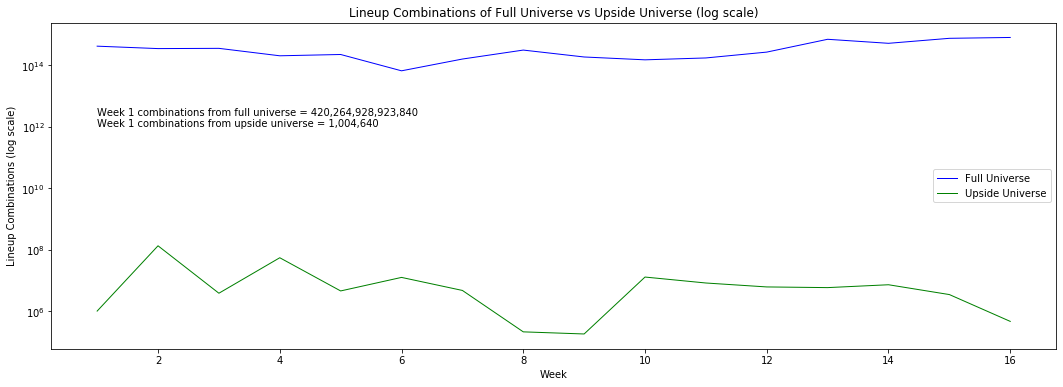

In [47]:
from math import factorial
import matplotlib.pyplot as pyplot

def nCr(n, r):
    return factorial(n) / (factorial(r) * factorial(n - r))

combinations_full = []
combinations_upside = []

weeks = [*range(1, 17)]

for week in weeks:
    num_qbs_full_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'QB')].shape[0]
    num_rbs_full_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'RB')].shape[0]
    num_wrs_full_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'WR')].shape[0]
    num_tes_full_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'TE')].shape[0]

    combinations_full_universe = num_qbs_full_universe * nCr(num_rbs_full_universe, 2) * nCr(num_wrs_full_universe, 3) * num_tes_full_universe * (num_rbs_full_universe + num_wrs_full_universe + num_tes_full_universe)
    combinations_full.append(combinations_full_universe)
    
    num_qbs_upside_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'QB') & (scoring_2019_df['has_upside'] == 1)].shape[0]
    num_rbs_upside_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'RB') & (scoring_2019_df['has_upside'] == 1)].shape[0]
    num_wrs_upside_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'WR') & (scoring_2019_df['has_upside'] == 1)].shape[0]
    num_tes_upside_universe = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['position'] == 'TE') & (scoring_2019_df['has_upside'] == 1)].shape[0]
    
    combinations_upside_universe = num_qbs_upside_universe * nCr(num_rbs_upside_universe, 2) * nCr(num_wrs_upside_universe, 3) * num_tes_upside_universe * (num_rbs_upside_universe + num_wrs_upside_universe + num_tes_upside_universe)
    combinations_upside.append(combinations_upside_universe)
    
pyplot.figure(figsize=(18, 6))
pyplot.yscale('log')
pyplot.plot(weeks, combinations_full, color = 'blue', linewidth = 1, label = "Full Universe")
pyplot.plot(weeks, combinations_upside, color = 'green', linewidth = 1, label = "Upside Universe")
pyplot.text(1, 1000000000000, 'Week 1 combinations from full universe = 420,264,928,923,840\nWeek 1 combinations from upside universe = 1,004,640')
pyplot.xlabel('Week')
pyplot.ylabel('Lineup Combinations (log scale)')
pyplot.title('Lineup Combinations of Full Universe vs Upside Universe (log scale)')

pyplot.legend()

# Step 6 Complete: Using odds to filter the player universe makes life easier

<hr style="border:2px solid gray"> </hr>

# Step 7: Test the smaller player universe against the full universe

## Optimize our lineups

In this section of the notebook, we're finally going to optimize our lineups. We're going to do this using the linear optimizer library [PuLP](https://github.com/coin-or/pulp). A linear optimization is an easy way to get the overall best lineup by maximizing points, putting a constraint on the salary of $50,000, and putting a constraint on the number of players at each position. It'll give us an overall view of how the model performs.

Note, when playing daily fantasy sports you likely more than just a single lineup so that you get exposure to more players. This expands your upside because, as we've said, it's hard to predict who will actually perform well. It also limits your downside because if a player gets injured, you get zero points. As you saw above, when you look at the full universe of players there are trillions of lineups making it much hard to find the top 10, 50, or 100 lineups to play. However, by limiting the universe to players with upside from the odds, it's much easier to find the top 10, 50, or however many lineups you need.

In [48]:
%conda install -c conda-forge pulp

Solving environment: | 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/linux-64::pandas==1.0.1=py36h0573a6f_0
  - defaults/linux-64::scikit-learn==0.22.1=py36hd81dba3_0
  - defaults/linux-64::bkcharts==0.2=py36_0
  - defaults/linux-64::pytest-arraydiff==0.3=py36h39e3cac_0
  - defaults/linux-64::bottleneck==1.3.2=py36heb32a55_0
  - defaults/linux-64::pywavelets==1.1.1=py36h7b6447c_0
  - defaults/noarch::pytest-astropy==0.8.0=py_0
  - defaults/linux-64::numexpr==2.7.1=py36h423224d_0
  - defaults/linux-64::h5py==2.10.0=py36h7918eee_0
  - defaults/linux-64::bokeh==1.4.0=py36_0
  - defaults/linux-64::numpy-base==1.18.1=py36hde5b4d6_1
  - defaults/linux-64::astropy==4.0=py36h7b6447c_0
  - defaults/linux-64::patsy==0.5.1=py36_0
  - defaults/linux-64::scikit-image==0.16.2=py36h0573a6f_0
  - defaults/linux-64::matplotlib-base==3.1.3=py36hef1b27d_0
  - defaults/linux-64::imageio==2.6.1=py36_0
  - defaul

This is a helper function to get the data ready for our linear optimizer. We put the salaries and points into a dict so that for each position, we have each player along with their salary and points to pass to the linear optimizer. 

In [49]:
def salaries_and_points_from_df(df, points_field):
    salaries = {}
    points = {}

    for position in ['QB', 'WR', 'RB', 'TE']:
        players_at_position = df[df['position'] == position]
    
        player_ids_at_position = list(players_at_position['player_id'])
    
        salaries_at_position = dict(zip(player_ids_at_position, players_at_position['salary']))
        points_at_position = dict(zip(player_ids_at_position, players_at_position[points_field]))
    
        salaries[position] = salaries_at_position
        points[position] = points_at_position

    return { 'salaries': salaries, 'points': points }

This is a helper function the uses PuLP to find the optimal lineup given players, their points, and their salary. It stays within the salary cap, limits of the number of players by position so the roster is valid, and produces the lineup with the players that maximize points.

In [50]:
import pulp

def run_linear_optimization(salaries, points, num_position_available):
    # Create a binary variable grouped by position that tells us if the player is or is not included in the lineup.
    players_by_position_var = { 
        position: pulp.LpVariable.dict(position, players, cat = "Binary") for position, players in salaries.items() 
    }
    
    # Create a problem using LpMaximize since we want to maximize points.
    optimization_problem = pulp.LpProblem("best-lineup", pulp.LpMaximize)
    
    point_sums = []
    salary_sums = []

    for position, players in players_by_position_var.items():
        # Create a sum of all players at their position by salary. These get flipped on and off to keep salary below 50000.
        salary_sums += pulp.lpSum([salaries[position][i] * players_by_position_var[position][i] for i in players])
        
        # Create a sum of all players at their position by points scored. These get flipped on and off to maximize points while staying within our constraints.
        point_sums += pulp.lpSum([points[position][i] * players_by_position_var[position][i] for i in players])
        
        # Add a constraint that have fewer than N players at their position where N is the number of players allowed at that position.
        optimization_problem += pulp.lpSum([players_by_position_var[position][i] for i in players]) <= num_position_available[position]
    
    # We want to maximize points so add that sum to the problem.
    optimization_problem += pulp.lpSum(point_sums)
    
    # We need salary to stay below 50000
    optimization_problem += pulp.lpSum(salary_sums) <= 50000
    
    optimization_problem.solve()
    
    player_ids_to_play = []

    for variable in optimization_problem.variables():
        if variable.varValue != 0:
            player_ids_to_play.append(variable.name.split('_')[1])
            
    return player_ids_to_play

This is another helper function that runs the linear optimization based on the specified scoring field. We run three optimizations because a FLEX player can be a WR, RB, or TE so we change the constraints in each optimization to reflect that and then pick the best point total overall.

In [51]:
def actual_points_sum_for_week(df, scoring_field):
    salaries_and_points = salaries_and_points_from_df(df, scoring_field)

    player_ids_4_wrs = run_linear_optimization(
        salaries_and_points['salaries'], 
        salaries_and_points['points'], 
        {
            "QB": 1,
            "RB": 2,
            "WR": 4,
            "TE": 1,
        }
    )

    player_ids_3_rbs = run_linear_optimization(
        salaries_and_points['salaries'], 
        salaries_and_points['points'], 
        {
            "QB": 1,
            "RB": 3,
            "WR": 3,
            "TE": 1,
        }
    )
        
    player_ids_2_tes = run_linear_optimization(
        salaries_and_points['salaries'], 
        salaries_and_points['points'], 
        {
            "QB": 1,
            "RB": 2,
            "WR": 3,
            "TE": 2,
        }
    )
    
    sum_4_wrs = df[(df['player_id'].isin(player_ids_4_wrs))]['actual_points'].sum()
    sum_3_rbs = df[(df['player_id'].isin(player_ids_3_rbs))]['actual_points'].sum()
    sum_2_tes = df[(df['player_id'].isin(player_ids_2_tes))]['actual_points'].sum()

    return max([ sum_4_wrs, sum_3_rbs, sum_2_tes ])

Finally, we're optimizing our lineups. For each week of the season, we're going to get the optimal points by looking at:

1. The actual points. The data is from 2019 so, we know what actually happened. We'll calculate that to see what the best lineup was overall.
2. The points predicted by Stats Perform, using the entire player universe. 
3. The points predicted by Stats Perform, limited to players with upside from the odds. This allows us to optimize from a smaller universe which makes it easier to generate multiple optimal lineups given the smaller sample size.

In [52]:
actual_points_by_week = []
predicted_points_by_week = []
predicted_points_with_upside_by_week = []

weeks = [*range(1, 17)]

for week in weeks:
    week_df = scoring_2019_df[(scoring_2019_df['week'] == week)]
    week_with_upside_df = scoring_2019_df[(scoring_2019_df['week'] == week) & (scoring_2019_df['has_upside'] == 1)]

    actual_points_by_week.append(actual_points_sum_for_week(week_df, 'actual_points'))
    predicted_points_by_week.append(actual_points_sum_for_week(week_df, 'predicted_points'))
    predicted_points_with_upside_by_week.append(actual_points_sum_for_week(week_with_upside_df, 'predicted_points'))

# Step 7 Complete: Success, the smaller player universe is just as good

You can see below the purple line (optimized with upside) works just as well, if not better, than an optimization using the entire universe. 

When looking for the single best lineup using a linear optimizer this is obviously not that big of a deal because we can just as easily determine the best lineup without limiting the player universe to players with upside. But, in a contest when you want to play multiple lineups and need to compute all options, being able to limit the universe so you have fewer options to look at makes it computationally practical to solve.

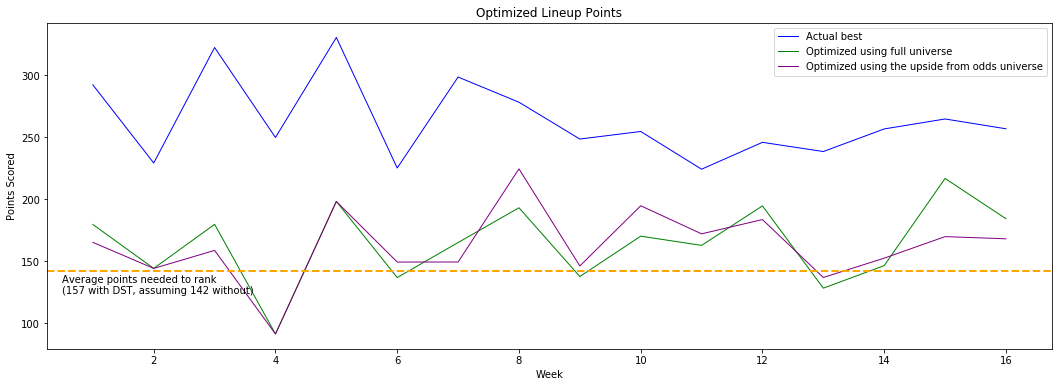

In [53]:
import matplotlib.pyplot as pyplot

pyplot.figure(figsize=(18, 6))
pyplot.plot(weeks, actual_points_by_week, color = 'blue', linewidth = 1, label = "Actual best")
pyplot.plot(weeks, predicted_points_by_week, color = 'green', linewidth = 1, label = "Optimized using full universe")
pyplot.plot(weeks, predicted_points_with_upside_by_week, color = 'purple', linewidth = 1, label = "Optimized using the upside from odds universe")
pyplot.axhline(y = 142, color='orange', linewidth = 2, linestyle = 'dashed')
pyplot.text(0.5, 124, 'Average points needed to rank\n(157 with DST, assuming 142 without)')
pyplot.xlabel('Week')
pyplot.ylabel('Points Scored')
pyplot.title('Optimized Lineup Points')

pyplot.legend()

<hr style="border:2px solid gray"> </hr>

# What's next?

<ins>**Ways you can improve this model**</ins>

* Add scoring for DST by looking at boxscore from IDP.
* Find the optimal percentile for fantasy points to make sit/start decisions. There's a tradeoff here when if you set too high of a percentile, players are aggressively labeled as not having upside from the odds. With too few players, you can't produce a valid lineup.
* Find the optimal qualifiers (eg pass attempts) for inclusion in the model. Too few attempts introduces a lot of noise into the model. For example, it'll look at data points from players that don't get playing time which isn't that useful. Too many attempts and players are aggressively labeled as not having upside from the odds.
* Shuffle the training and verification data. We kept the order static in this demo so that the model would have predictable results but, ordinarily you wan't to randomize the order of your data before training. 
* Carve off test data for the learner.
* Tweak model [parameters](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html#sagemaker.estimator.Estimator.set_hyperparameters) (eg batch size, learner).